# Simple 2D packing example with simple boxes


### Redoing. Cite for new attempt.

@inproceedings{
zhao2022learning,
title={Learning Efficient Online 3D Bin Packing on Packing Configuration Trees},
author={Hang Zhao and Yang Yu and Kai Xu},
booktitle={International Conference on Learning Representations},
year={2022},
url={https://openreview.net/forum?id=bfuGjlCwAq}
}

# Working one piece at a time:

## Bounding Box

Reference: [Computing bounding box for a list of coordinates in Python](https://techoverflow.net/2017/02/23/computing-bounding-box-for-a-list-of-coordinates-in-python/)

libraries for bounding box

In [6]:
!pip install git+https://github.com/ulikoehler/UliEngineering.git

/bin/bash: /home/cim/anaconda3/envs/packing_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/ulikoehler/UliEngineering.git to /tmp/pip-req-build-jeaatqex
  Running command git clone -q https://github.com/ulikoehler/UliEngineering.git /tmp/pip-req-build-jeaatqex
  Resolved https://github.com/ulikoehler/UliEngineering.git to commit f4d25d3f76925a0fc4f64aacf908db3f639baa64
     |████████████████████████████████| 55 kB 3.7 MB/s eta 0:00:01
  Created wheel for UliEngineering: filename=UliEngineering-0.3.8-py3-none-any.whl size=96069 sha256=d81f6d5cfe22580b0e6d294ab12ed24f4747d7cf05ae254c7ecda9939154549d
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2g1b1e4/wheels/fc/5d/63/5f11d6e16f564c28980f18ccf9c7ac74e07acf515a2148c202
Successfully built UliEngineering


In [7]:
import numpy as np
from UliEngineering.Math.Coordinates import BoundingBox

Using the BoundingBox function:
Feed a list of coordinate pairs: `coords = np.asarray(coords)`


Where 


          coords = [(6.74219, -53.57835),
                    (6.74952, -53.57241),
                    (6.75652, -53.56289),
                    (6.74756, -53.56598),
                    (6.73462, -53.57518)]

for example

Then use the function:
            `BoundingBox(coords)`

## Empty Maximal Spaces

Representation of free space in the bin.

One reference [Simulated Annealing](https://github.com/setarehabhari/Simulated-Annealing/blob/main/SA-CSP.ipynb), but I don't understand temperature

## Environment

### Wrapper on gym.env for a Discrete class (our bin in 1 cm squares). Reference [Gym Wrappers](https://alexandervandekleut.github.io/gym-wrappers/)

                    class DiscreteToBoxWrapper(gym.ObservationWrapper):
                        def __init__(self, env):
                            super().__init__(env)
                            assert isinstance(env.observation_space, gym.spaces.Discrete), \
                                "Should only be used to wrap Discrete envs."
                            self.n = self.observation_space.n
                            self.observation_space = gym.spaces.Box(0, 1, (self.n,))

                        def observation(self, obs):
                            new_obs = np.zeros(self.n)
                            new_obs[obs] = 1
                            return new_obs

### Reshape 2D array to 1D to feed through neural network

## Ray

Example hyperparameters for neural network

In [8]:
Bin_x, Bin_y = 600, 600

H = 200  # The number of hidden layer neurons.
gamma = 0.99  # The discount factor for reward. <- Not sure on this one
decay_rate = 0.99  # The decay factor for RMSProp leaky sum of grad^2.
D = Bin_x * Bin_y  # The input dimensionality: 600x600 grid.
learning_rate = 1e-4  # Magnitude of the update.

Neural Network from [Ray Ping Pong example](https://docs.ray.io/en/latest/ray-core/examples/plot_pong_example.html#neural-network) and [Karpathy pg-pong.py GitHub](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)

In [ ]:
class Model(object):
    """This class holds the neural network weights."""

    def __init__(self):
        self.weights = {}
        self.weights["W1"] = np.random.randn(H, D) / np.sqrt(D)
        self.weights["W2"] = np.random.randn(H) / np.sqrt(H)

    def policy_forward(self, x):
        h = np.dot(self.weights["W1"], x)
        h[h < 0] = 0  # ReLU nonlinearity.
        logp = np.dot(self.weights["W2"], h)
        # Softmax
        p = 1.0 / (1.0 + np.exp(-logp))
        # Return probability of taking action 2, and hidden state.
        return p, h

    def policy_backward(self, eph, epx, epdlogp):
        """Backward pass to calculate gradients.

        Arguments:
            eph: Array of intermediate hidden states.
            epx: Array of experiences (observations.
            epdlogp: Array of logps (output of last layer before softmax/

        """
        dW2 = np.dot(eph.T, epdlogp).ravel()
        dh = np.outer(epdlogp, self.weights["W2"])
        # Backprop relu.
        dh[eph <= 0] = 0
        dW1 = np.dot(dh.T, epx)
        return {"W1": dW1, "W2": dW2}

    def update(self, grad_buffer, rmsprop_cache, lr, decay):
        """Applies the gradients to the model parameters with RMSProp."""
        for k, v in self.weights.items():
            g = grad_buffer[k]
            rmsprop_cache[k] = decay * rmsprop_cache[k] + (1 - decay) * g ** 2
            self.weights[k] += lr * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)


def zero_grads(grad_buffer):
    """Reset the batch gradient buffer."""
    for k, v in grad_buffer.items():
        grad_buffer[k] = np.zeros_like(v)

# Previous attempt below
(May want to have for later)

Import libraries

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

/home/cim/anaconda3/envs/packing_env/lib/python3.7/site-packages/ale_py/roms/__init__.py:89: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  ROMS = resolve_roms()


In this environment an agent places 2D boxes in a 2D container.
1. The agent needs to pack as many boxes as possible without overlapping them.
2. The episode terminates when the container is full or no more boxes can be placed.

### ContainerLevel Class
Creating a class to model the bottom level of a shipping container.
* Define in the `__init__` function the observation and the action spaces.
* Implement attribute `canvas` 
* Implement screen area `x_min, y_min, x_max, y_max`
* Implement `elements` - this stores elements in the screen (the already packed box)
* helper function `draw_elements_on_canvas` that places the boxes icons in the container at their respective positions
* `reset` : resets the environment to its initial state and returns the initial observation.
* `step`: Executes a step by placing a box in the environment
    * returns the new observation
    * reward
    * completion status
    * and other information

In [16]:
class ContainerLevel(Env):
    def __init__(self, obs_x=600, obs_y=600, box_len=200, box_wid=200):
        super(ContainerLevel, self).__init__()

        # Define 2D packing space
        self.observation_shape = (obs_x, obs_y, 3) # **Need to have dimensions passed
        self.observation_space = spaces.Box(low = np.zeros(self.observation_space),
                                            high = np.ones(self.observation_space),
                                            dtype = np.float64)

        # Define an action space
        self.action_space = spaces.Discrete(6, ) # what is the 6?

        # Creating a canvas for rendering
        self.canvas = np.ones(self.observation_shape) * 1

        # Define elements present in the environment
        self.elements = []

        # Permissible area where the boxes can be located in container
        # **need to adjust this to be smaller when there are other boxes
        # Pass information back to space with 2D grid of heights.
        self.y_min = int(self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int(self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]
        self.box_len = box_len
        self.box_wid = box_wid

    def draw_elements_on_canvas(self):
        # Initialize the canvas
        self.canvas = np.ones(self.observation_shape)* 1

        # Draw the boxes on the canvas
        for elem in self.elements:
            elem_shape = elem.boxes.shape
            x, y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1],
                        x : x + elem_shape[0]] = elem.boxes

    def overlapping(self, elem1, elem2):
        # NEED TO LOOP OVER ALL BOXES IN CONTAINER
        # returns True if elem1 & elem2 overlap
        # defining boolean for whether there is overlap
        x_overlap = False
        y_overlab = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        # absolute distance between each dimension
        dist_x = abs(elem1_x - elem2_x)
        dist_y = abs(elem1_y - elem2_y)

        # minimum distance is 1/2 of each boxes' length or width
        elem_y_min = 0.5 * (elem1.box_wid + elem2.box_wid)
        elem_x_min = 0.5 * (elem1.box_len + elem2.box_len)

        if (dist_x < elem_x_min):
            x_overlap = True
        if (dist_y < elem_y_min):
            y_overlap = True

        if x_overlap and y_overlab:
            return True

        return False
    
    def reset(self):
        # Reset the reward
        self.ep_return = 0

        # Number of boxes
        self.boxes_count = 1

        # Determine a random place to initialize the first box
        # along one side of the container
        x = random.randrange(int(self.observation_shape[0] * 0.05),
                             int(self.observation_shape[0] * 1.0))
        y = random.randrange(int(self.observation_shape[1] * 0.05),
                             int(self.observation_shape[1] * 
                             1.0 )) # Would like to change this to box_len/observation_shape[1]
        self.boxes = Boxes('boxes', self.x_max, self.x_min, self.y_max, self.y_min, self.box_len, self.box_wid)
        self.boxes.set_position(x, y)          

        # Intialize the elements
        self.elements = [self.boxes]

        # Reset the canvas
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # return the observation of the state of the container
        return self.canvas

### Elements of the Environment - Boxes
* Starting with a `Point` base class to define any arbitrary point in the observation image.
* It has the following attribures:
    * `(x, y)`: position of the point on the image.
    * `(x_min, x_max, y_min, y_max)`: the permissible coordicates for the points - keeps the position values clamped to these limits.
    * `name` : name of the point
* Member functions are defined as:
    * `get_position` : get the coordinate of the point.
    * `set_position` : set the coordinate of the point to a certain value
    * `move` ?  - maybe we can call it `rotate` when we need it?

In [17]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min, box_len, box_wid):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.box_len = box_len
        self.box_wid = box_wid

    def set_position(self, x, y):
        # use box width (box_wid) and length (box_len)
        # Dimensions will be (x, y, z) so box is (box_len, box_wid, box_high)
        self.x = self.clamp(x, self.x_min, self.x_max - self.box_len)
        self.y = self.clamp(y, self.y_min, self.y_max - self.box_wid)

    def get_position(self):
        return (self.x, self.y)

    # rot_ang is the rotational angle in radians - for 2D: pi/2
    def rotate_xy(self, rot_ang):
        self.x += np.cos(rot_ang)
        self.y += np.sin(rot_ang)

        self.x = self.clamp(self.x, self.x_min, self.x_max - self.box_len)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.box_wid)

    # Here's the much needed part - clamp - to be sure boxes are in the container
    def clamp(self, n, minn, maxn):
        return (max(min(maxn, n), minn))

### The objects are boxes and need to have the attributes:
* `boxes` - the 2D footprint of a box 
* `(box_len, box_wid)` - the dimensions of the footprint of the box.

In [18]:
class Boxes(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min, box_len, box_wid):
        super(Boxes, self).__init__(name, x_max, x_min, y_max, y_min, box_len, box_wid)
        # self.boxes = cv2.imread('./images/4072102_box_delivery_package_parcel_shipping_icon.png') / 255.0
        self.boxes = cv2.imread('./images/Smiley_Square.png') / 255.0
        self.box_len = box_len
        self.box_wid = box_wid
        self.boxes = cv2.resize(self.boxes, (self.box_len, self.box_wid))


#### Observing initial container

original numbers 200 200
len, wid 200 200


/home/cim/anaconda3/envs/packing_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  import sys


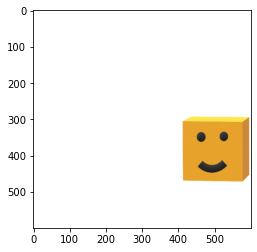

In [19]:
env = ContainerLevel()
obs = env.reset()
plt.imshow(obs)

Since our agent will be placing boxes, we need a function to determine whether any newly placed `Point` objects have overlapped any existing objects.

Now working on an agent. Our agent will be placing boxes into the container. Adding a definition of possible actions: *place*, *rotate right*, and *rotate left*. 

Currently unclear on how to add that functionality. Continuing.

In [ ]:
%%add_to ContainerLevel

def action_meanings(self):
    return{0: 'PlaceBox', 1: 'PickUpBox',
            2: 'MoveBoxRight', 3: 'MoveBoxLeft',
            4: 'MoveBoxUp', 5: 'MoveBoxDown',
            6:'RotateRight', 7: 'RotateLeft'}

How to see if the action is valid.

In [ ]:
# Assert that is is a valid action
assert self.action_space.contains(action), "Invalid Action"

How to determine if there is overlap. If the centers of the two boxes are closer than the length for the x coordinates or the width for the y coordinates, there is overlap.

Also, the overlap will need to be checked with all boxes in the container, so this will need to be looped over for the number of boxes already in the container.


```
def overlapping(self, elem1, elem2):
    # returns True if elem1 & elem2 overlap
    # defining boolean for whether there is overlap
    x_overlap = False
    y_overlap = False

    elem1_x, elem1_y = elem1.get_position()
    elem2_x, elem2_y = elem2.get_position()

    # absolute distance between each dimension
    dist_x = abs(elem1_x - elem2_x)
    dist_y = abs(elem1_y - elem2_y)

    # minimum distance is 1/2 of each boxes' length or width
    elem_y_min = 0.5 * (elem1.box_wid + elem2.box_wid)
    elem_x_min = 0.5 * (elem1.box_len + elem2.box_len)

    if (dist_x < elem_x_min):
        x_overlap = True
    if (dist_y < elem_y_min):
        y_overlap = True

    if x_overlap and y_overlap:
        return(True)

    return(False)
```